# Train and test split + Copying images into train and test folders

## 1. Reload images dataset

In [2]:
import pandas as pd

images_dataset_path = 'data/datasets/images.csv'
df_images = pd.read_csv(images_dataset_path)

display(df_images.columns)
display(df_images.index[:10])

Index(['id_video', 'code', 'folder', 'file_name', 'file_path', 'frame_index',
       'timestamp', 'initial_timestamp', 'seen', 'tags'],
      dtype='object')

RangeIndex(start=0, stop=10, step=1)

---
## 2. Preprocess the dataset

In [3]:
from modules.octa_video_util import _assign_tag
from modules.octa_video_util import filter_by_query

#### Create categorical field from tag priority list

In [4]:
# Create unique tag column based on class priority list
default_tag = 'normal'
tags_priority_list = ['alagamento', 'bolsão', 'lâmina', 'poça', 'transbordo']

df_images['tag'] = df_images['tags'].apply(lambda tags_list: _assign_tag(tags_list, tags_priority_list, default_tag))
display(df_images.tag.value_counts())

tag
normal        147594
poça           67391
lâmina          8759
alagamento      4335
bolsão          4235
transbordo      2237
Name: count, dtype: int64

#### Drop categories

In [5]:
df_images = df_images[df_images['tag'] != 'transbordo']

#### Binarize categorical variable

In [6]:
target_classes = ['lâmina', 'bolsão', 'alagamento']

# Binarize categorical variable from list of target classes
df_images['flood'] = df_images['tag'].isin(target_classes).astype(int)

display(df_images['flood'].value_counts())
print()
display(df_images.index[:10])

flood
0    214985
1     17329
Name: count, dtype: int64

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')

#### Filter images

In [7]:
query_params = {'seen': True}

# Filter dataset of images by query
df_sample = filter_by_query(df_images, query_params).copy()

display(df_sample['flood'].value_counts())
print()
display(df_sample.index[:10])

flood
0    214985
1     17329
Name: count, dtype: int64

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')

---
## 3. Shuffling

In [8]:
import numpy as np
import secrets
secrets.randbits(128)

def RNG():
    return np.random.default_rng(122807528840384100672342137672332424406)

# Example usage
# rng = RNG()
# idx = rng.choice(data.index, len(data), replace=replace, shuffle=False)

#### Sampling parameters

In [81]:
target_variable = 'flood'
multiclass_target_variable = 'tag'
groups_variable = 'code'

max_samples = 2000
replace = False
random_state = 0

#### Shuffle Samples

In [53]:
data = df_sample.copy()

data = data.sample(n=len(data), replace=replace, random_state=random_state)

display(data.index[:10])

Index([117849, 140116, 22843, 90909, 112686, 5198, 213855, 197013, 179200,
       168345],
      dtype='int64')

#### Get x and y (features and target variable)

In [54]:
# Get x and y
X = data.drop(target_variable, axis=1)
Y = data[target_variable].copy()

Y_multi = data[multiclass_target_variable] 
groups = data[groups_variable].copy()

display(Y.value_counts())
print()
display(Y_multi.value_counts())

flood
0    214985
1     17329
Name: count, dtype: int64

tag
normal        147594
poça           67391
lâmina          8759
alagamento      4335
bolsão          4235
Name: count, dtype: int64

---
## 4. Balanced sampling per camera

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import numpy as np
def group_even_undersample(x, y, groups, prct=0.5, n=None, random_state=None):
    group_cnt = groups.value_counts()
    if n is None:
        n = int(np.percentile(group_cnt, prct * 100))
    index = []
    for group in group_cnt.index:
        index += y[groups == group].sample(min(n, group_cnt[group]), replace=False, random_state=random_state).index.tolist()
    return x.loc[index], y.loc[index]

#### Class count per camera (excluding cameras without positive samples)

code,278.0,326.0,235.0,3181.0,92.0,38.0,1671.0,1538.0,1994.0,1083.0,...,339.0,1430.0,267.0,94.0,384.0,442.0,1606.0,1147.0,268.0,1881.0
class 0,18734,10354,7366,5578,3791,2700,2700,2120,1708,1405,...,249,232,228,225,180,157,127,105,69,45
class 1,3238,1112,2266,1800,516,270,270,1935,122,156,...,126,90,210,225,135,675,109,405,19,45


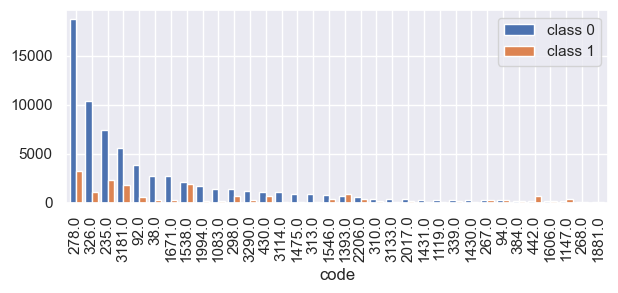

In [56]:
cnt_0 = groups[Y == 0.0].value_counts()
cnt_1 = groups[Y == 1.0].value_counts()
cnt_0 = cnt_0.loc[cnt_1.index].sort_values(ascending=False)

code_class_cnt = pd.concat([cnt_0.rename('class 0'), cnt_1.rename('class 1')], axis=1)
display(code_class_cnt.T)

fig = plt.figure(figsize=(7, 2.5))
ax = fig.subplots(1, 1)

code_class_cnt.plot.bar(width=0.8, ax=ax)
plt.show()

#### Undersample per camera

In [57]:
cnt_0 = groups[Y == 0.0].value_counts()
cnt_1 = groups[Y == 1.0].value_counts()

index = []
for code in cnt_1.index:
    Y_code = Y[groups == code]
    n_samples = min(cnt_0.loc[code], cnt_1.loc[code])
    index += Y_code[Y_code == 1.0].index.tolist()
    index += Y_code[Y_code == 0.0].sample(n_samples, replace=replace, random_state=random_state).index.tolist()

x_res = X.loc[index]
y_res = Y.loc[index]
y_multi_res = Y_multi.loc[index]
groups_res = groups.loc[index]

print('Total samples:', len(y_res))
print()
display(y_res.value_counts())
print()
print(y_multi_res.value_counts())
print()
display(y_res.index)

Total samples: 33681



flood
1    17329
0    16352
Name: count, dtype: int64


tag
normal        10803
lâmina         8759
poça           5549
alagamento     4335
bolsão         4235
Name: count, dtype: int64



Index([170628, 214759,  95782, 214947, 170520, 209463, 159342, 177932, 177869,
       157941,
       ...
       197704, 182534, 188888, 188969, 197638, 197659, 197565, 204224, 182592,
       182600],
      dtype='int64', length=33681)

#### Class count per camera (excluding cameras without positive samples)

code,278.0,235.0,1538.0,3181.0,326.0,1393.0,442.0,298.0,430.0,92.0,...,1606.0,3133.0,1430.0,1881.0,1119.0,1431.0,3114.0,268.0,313.0,1475.0
class 0,3238,2266,1935,1800,1112,690,157,630,630,516,...,109,90,90,45,40,28,21,19,15,14
class 1,3238,2266,1935,1800,1112,849,675,630,630,516,...,109,90,90,45,40,28,21,19,15,14


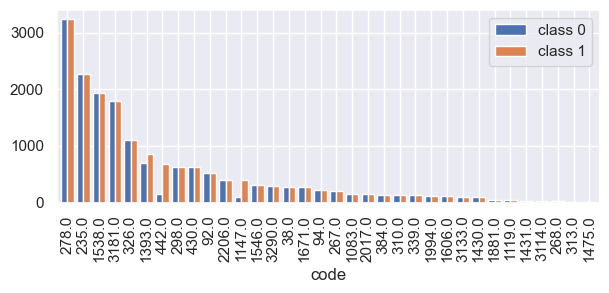

In [58]:
cnt_0 = groups_res[y_res == 0.0].value_counts()
cnt_1 = groups_res[y_res == 1.0].value_counts()
cnt_0 = cnt_0.loc[cnt_1.index]

code_class_cnt = pd.concat([cnt_0.rename('class 0'), cnt_1.rename('class 1')], axis=1)
display(code_class_cnt.T)

fig = plt.figure(figsize=(7, 2.5))
ax = fig.subplots(1, 1)

code_class_cnt.plot.bar(width=0.8, ax=ax)
plt.show()

#### Even groups sampling

In [59]:
msk_0 = y_res == 0.0
msk_1 = y_res == 1.0

x_even_0, y_even_0 = group_even_undersample(x_res[msk_0], y_res[msk_0], groups_res[msk_0], n=100, random_state=random_state)
x_even_1, y_even_1 = group_even_undersample(x_res[msk_1], y_res[msk_1], groups_res[msk_1], n=100, random_state=random_state)

y_even = pd.concat([y_even_0, y_even_1])
x_even = X.loc[y_even.index]
groups_even = groups.loc[y_even.index]
y_multi_even = Y_multi.loc[y_even.index]

print('Total samples:', len(y_even))
print()
display(y_even.value_counts())
print()
print(y_multi_even.value_counts())
print()
display(y_even.index)

Total samples: 5724



flood
0    2862
1    2862
Name: count, dtype: int64


tag
normal        1687
lâmina        1326
poça          1175
alagamento     883
bolsão         653
Name: count, dtype: int64



Index([163557, 160725, 163347, 178427, 161525, 178743, 178469, 159483, 158247,
        92150,
       ...
       188826, 188831, 188828, 188827, 188832, 188833, 188829, 188834, 188825,
       188824],
      dtype='int64', length=5724)

#### Class count per camera (excluding cameras without positive samples)

code,278.0,3290.0,1606.0,1994.0,339.0,310.0,384.0,2017.0,1083.0,235.0,...,2206.0,3133.0,1430.0,1881.0,1119.0,1431.0,3114.0,268.0,313.0,1475.0
class 0,100,100,100,100,100,100,100,100,100,100,...,100,90,90,45,40,28,21,19,15,14
class 1,100,100,100,100,100,100,100,100,100,100,...,100,90,90,45,40,28,21,19,15,14


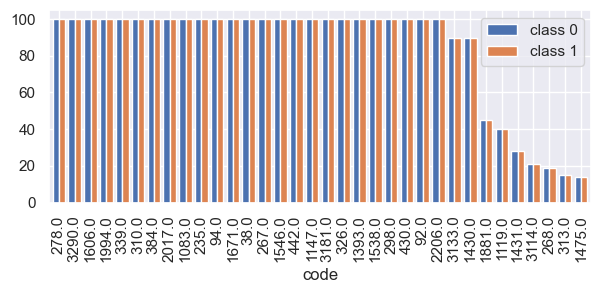

In [60]:
cnt_0 = groups_even[y_even == 0.0].value_counts()
cnt_1 = groups_even[y_even == 1.0].value_counts()
cnt_0 = cnt_0.loc[cnt_1.index]

code_class_cnt = pd.concat([cnt_0.rename('class 0'), cnt_1.rename('class 1')], axis=1)
display(code_class_cnt.T)

fig = plt.figure(figsize=(7, 2.5))
ax = fig.subplots(1, 1)

code_class_cnt.plot.bar(width=0.8, ax=ax)
# plt.legend(loc='lower left')
# plt.tight_layout()
plt.show()

#### Get `x_res`, `y_res` and `groups_res`

In [61]:
x_res = X.loc[y_even.index].copy()
y_res = Y.loc[y_even.index].copy()
groups_res = groups.loc[y_even.index].copy()

---
## 5. Train and Test Splitting

####  Optional · Stratified group KFold split

Obs: Best split result

In [79]:
from sklearn.model_selection import StratifiedGroupKFold

train_prct = 0.60
test_prct = 0.20
val_prct = 0.20

n_splits_test = int(1.0 / test_prct)
n_splits_val = int((1.0 - test_prct) / val_prct)

print('n_splits_test:', n_splits_test)
print('n_splits_val:', n_splits_val)

# Stratified group KFold testing  split
sgkf = StratifiedGroupKFold(n_splits=n_splits_test, shuffle=True, random_state=random_state)
for i, (train_index, test_index) in enumerate(sgkf.split(x_res, y_res, groups_res)):
    # Get first split folder
    break

X_train = x_res.iloc[train_index]
Y_train = y_res.iloc[train_index]
groups_train = groups_res.iloc[train_index]

X_test = x_res.iloc[test_index]
Y_test = y_res.iloc[test_index]
groups_test = groups_res.iloc[test_index]

# Stratified group KFold validation split
sgkf = StratifiedGroupKFold(n_splits=n_splits_val, shuffle=True, random_state=random_state)
for i, (train_index, val_index) in enumerate(sgkf.split(X_train, Y_train, groups_train)):
    break

X_val = X_train.iloc[val_index]
Y_val = Y_train.iloc[val_index]
groups_val = groups_train.iloc[val_index]

X_train = X_train.iloc[train_index]
Y_train = Y_train.iloc[train_index]
groups_train = groups_train.iloc[train_index]

print('\nTrain index:', Y_train.index[:10])
print('\nTest index:', Y_test.index[:10])
print('\nVal index:', Y_val.index[:10])

n_splits_test: 5
n_splits_val: 4

Train index: Index([163557, 160725, 163347, 178427, 161525, 178743, 178469, 159483, 158247,
       92150],
      dtype='int64')

Test index: Index([65282, 65010, 146541, 113353, 65273, 155073, 123222, 72950, 149072,
       125540],
      dtype='int64')

Val index: Index([196981, 216935, 211878, 186737, 215358, 180308, 190965, 191452, 191309,
       191561],
      dtype='int64')


#### Report group count and train and test samples for each class

In [74]:
def group_split_report(y_res, groups_res, Y_train, Y_test, Y_val):

    train_prct = len(Y_train) / len(y_res)
    test_prct = len(Y_test) / len(y_res)
    val_prct = len(Y_val) / len(y_res)
    groups_train = groups_res.loc[Y_train.index].unique()
    groups_test = groups_res.loc[Y_test.index].unique()
    groups_val = groups_res.loc[Y_val.index].unique()
    
    class_count = y_res.value_counts()
    train_class_count = Y_train.value_counts()
    test_class_count = Y_test.value_counts()
    val_class_count = Y_val.value_counts()
    train_class_prct = [train_class_count[0] / class_count[0], train_class_count[1] / class_count[1]]
    test_class_prct = [test_class_count[0] / class_count[0], test_class_count[1] / class_count[1]]
    val_class_prct = [val_class_count[0] / class_count[0], val_class_count[1] / class_count[1]]
    train_class_ratio = round(Y_train.value_counts(normalize=True).loc[0] * 100, 2)
    test_class_ratio = round(Y_test.value_counts(normalize=True).loc[0] * 100, 2)
    val_class_ratio = round(Y_val.value_counts(normalize=True).loc[0] * 100, 2)
    
    print('Groups intersecting train and test sets:', len(set(groups_train).intersection(groups_test)))
    print('Groups intersecting train and val sets:', len(set(groups_train).intersection(groups_val)))
    print('Groups intersecting test and val sets:', len(set(groups_test).intersection(groups_val)))
    print()
    
    stats = pd.DataFrame(
        [[len(groups_train), len(groups_test), len(groups_val)],
        [len(Y_train), len(Y_test), len(Y_val)],
        [round(train_prct * 100, 2), round(test_prct * 100, 2), round(val_prct * 100, 2)],
        [train_class_count[0], test_class_count[0], val_class_count[0]],
        [train_class_count[1], test_class_count[1], val_class_count[1]],
        [round(train_class_prct[0] * 100, 2), round(test_class_prct[0] * 100, 2), round(val_class_prct[0] * 100, 2)],
        [round(train_class_prct[1] * 100, 2), round(test_class_prct[1] * 100, 2), round(val_class_prct[1] * 100, 2)],
        [train_class_ratio, test_class_ratio, val_class_ratio]],
        columns=['train', 'test', 'val'], index=['groups', 'total', 'total (%)', '0', '1', '0 (%)', '1 (%)', 'class ratio (%)']
    ).T

    return stats


# Example usage

print('Total samples:', len(y_res))
stats = group_split_report(y_res, groups_res, Y_train, Y_test, Y_val)
display(stats)

Total samples: 5724
Groups intersecting train and test sets: 0
Groups intersecting train and val sets: 0
Groups intersecting test and val sets: 0



,groups,total,total (%),0,1,0 (%),1 (%),class ratio (%)
train,21.0,3302.0,57.69,1651.0,1651.0,57.69,57.69,50.0
test,7.0,1242.0,21.70,621.0,621.0,21.70,21.70,50.0
val,6.0,1180.0,20.61,590.0,590.0,20.61,20.61,50.0


#### Report split: Number of samples per class and code

Train codes,278.0,3290.0,1606.0,339.0,1083.0,235.0,94.0,267.0,2206.0,430.0,...,326.0,3181.0,1538.0,3133.0,1881.0,1119.0,1431.0,268.0,313.0,1475.0
class 0,100,100,100,100,100,100,100,100,100,100,...,100,100,100,90,45,40,28,19,15,14
class 1,100,100,100,100,100,100,100,100,100,100,...,100,100,100,90,45,40,28,19,15,14


Test codes,298.0,1147.0,1546.0,38.0,2017.0,384.0,3114.0
class 0,100,100,100,100,100,100,21
class 1,100,100,100,100,100,100,21


Validation codes,442.0,92.0,1671.0,310.0,1994.0,1430.0
class 0,100,100,100,100,100,90
class 1,100,100,100,100,100,90


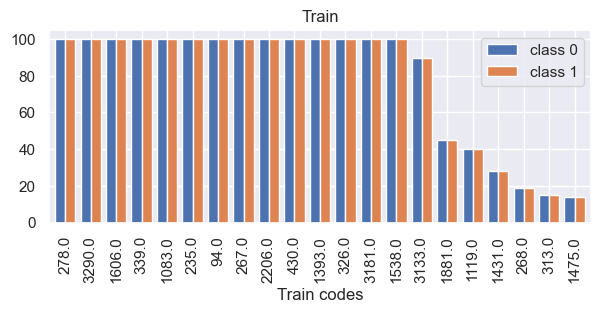

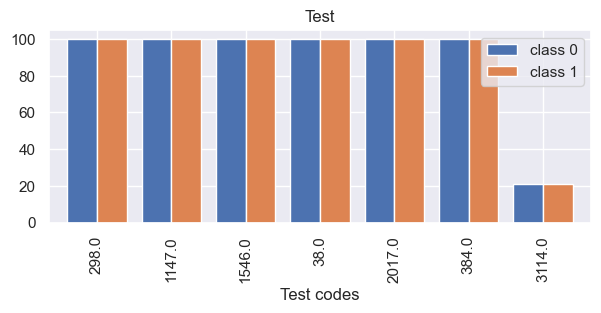

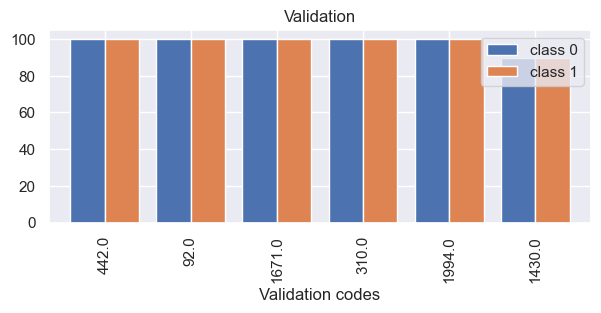

In [75]:
for y_i, g_i, title in zip((Y_train, Y_test, Y_val), (groups_train, groups_test, groups_val), ('Train', 'Test', 'Validation')):

    cnt_0 = g_i[y_i == 0.0].value_counts()
    cnt_1 = g_i[y_i == 1.0].value_counts()
    cnt_0 = cnt_0.loc[cnt_1.index]
    
    code_class_cnt = pd.concat([cnt_0.rename('class 0'), cnt_1.rename('class 1')], axis=1)
    code_class_cnt.index.name = f'{title} codes'
    display(code_class_cnt.T)

for y_i, g_i, title in zip((Y_train, Y_test, Y_val), (groups_train, groups_test, groups_val), ('Train', 'Test', 'Validation')):

    cnt_0 = g_i[y_i == 0.0].value_counts()
    cnt_1 = g_i[y_i == 1.0].value_counts()
    cnt_0 = cnt_0.loc[cnt_1.index]
    
    code_class_cnt = pd.concat([cnt_0.rename('class 0'), cnt_1.rename('class 1')], axis=1)
    code_class_cnt.index.name = f'{title} codes'
    
    fig = plt.figure(figsize=(7, 2.5))
    ax = fig.subplots(1, 1)
    
    code_class_cnt.plot.bar(width=0.8, ax=ax, title=title)
    # plt.legend(loc='lower left')
    # plt.tight_layout()
    plt.show()

---
## 6. Copy images into train and test folders

#### Copy images with `train_index`and `test_index` into structured 'train' and 'test' folders

In [23]:
from modules.octa_video_util import copy_images_to_folders

base_directory = 'data/images'
target_directory = 'data/splits/sgkf-8-1-1'
# dataset = data.copy()
dataset = data.copy()
file_path_field = 'file_path'
label_field = 'flood'
train_indexes = list(Y_train.index)
test_indexes = list(Y_test.index)
val_indexes = list(Y_val.index)

copy_images_to_folders(
    base_directory, target_directory, dataset,
    train_indexes, test_indexes, val_indexes,
    file_path_field=file_path_field, tag_field=label_field
)

Copying images to train folders:
Processed 1707/1707 files (100.00%) - Found: 1707/1707
Copying images to test folders:
Processed 231/231 files (100.00%) - Found: 231/231
Copying images to val folders:


#### Save dataframe of sample images

In [24]:
target_directory = 'data/splits/sgkf-8-1-1'

data_train = data.loc[Y_train.index]
data_test = data.loc[Y_test.index]
data_val = data.loc[Y_val.index]

data_train['set'] = 'train'
data_test['set'] = 'test'
data_val['set'] = 'val'

data_split_df = pd.concat([data_train, data_test, data_val])

data_split_df.to_csv(f'{target_directory}/images.csv')
print(f'split dataframe saved with shape: {data_split_df.shape}')

split dataframe saved with shape: (2163, 13)


#### Count save images

In [25]:
import os

target_directory = 'data/splits/sgkf-8-1-1'

print('train:', len(os.listdir(f'{target_directory}/train/0')), len(os.listdir(f'{target_directory}/train/1')))
print('test:', len(os.listdir(f'{target_directory}/test/0')), len(os.listdir(f'{target_directory}/test/1')))
print('val:', len(os.listdir(f'{target_directory}/val/0')), len(os.listdir(f'{target_directory}/val/1')))

train: 863 843
test: 108 123
val: 108 117
